In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.optimize import line_search
from functools import reduce
from collections import defaultdict
from scipy.stats import multivariate_normal
from sklearn import datasets

h = 0.001

# Linear regression with gradient descent

In [4]:
#function-object for linear_search in bfgs-method implemented in the next cells
def compute_gradient(f):
    def gradients(x):
        I = np.eye(len(x))
        return np.array([(f(x + h*I_) - f(x - h*I_))/(2.0*h) for I_ in I])
    return gradients

#numerical approximation of gradient with asymptotic precision o(h**2)
def gradient(f, x):
    I = np.eye(len(x))
    return np.array([(f(x + h*I_) - f(x - h*I_))/(2.0*h) for I_ in I])

#gradient method with dividing of step
def gradient_method(f, x, init_rate=0.1, delta=0.5, theta=0.001, max_iter=200):
    iteration = 1
    current_x = x
    while True:
        next_x = current_x - init_rate*gradient(f, current_x)
        rate = init_rate
        while f(next_x) - f(current_x) > -theta*rate*np.linalg.norm(gradient(f, current_x))**2: 
            rate = rate*delta
            next_x = current_x - rate*gradient(f, current_x)
        if max_iter < iteration: 
            break
        
        iteration += 1
        current_x = next_x
    return next_x

In [5]:
def linear_regression(train_data):
    #weights x, train_data - set of vectors and output for prediction
    cost_function = lambda x: 1.0/len(train_data)*np.sum((x[0] + x[1]*train_data[0] - train_data[1])**2) 
    params = gradient_method(cost_function, x=np.array([0.0, 0.0]))
    return params

## Generate simple train data for estimation and visualisation. 

### Linear regression is a consequence of maximum likelihood estimation, because cost function appears from maximization of likelihood function: we suppose that noise has centred normal distribution and compute product of probabilities of realization random variable (y = y_model + noise). After that we can see that MLE is equivalent to minimization squared norm with some coeff.

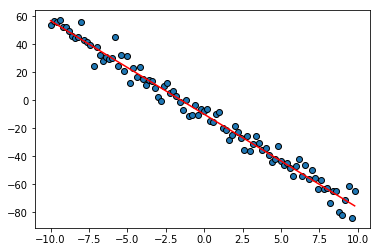

In [6]:
params = np.zeros(2)
params[0] = np.random.uniform(-10.0, 10.0)
params[1] = np.random.uniform(-10.0, 10.0)

noise_std = 5

possible_x = np.arange(-10.0, 10.0, 0.2)

train_data = np.array([[x, params[0] + params[1]*x + np.random.normal(scale=noise_std)] for x in possible_x])

estimated_params = linear_regression([train_data[:, 0], train_data[:, 1]])

plt.scatter(train_data[:, 0], train_data[:, 1], cmap='autumn', edgecolors='black', linewidth=1)
plt.plot(possible_x, estimated_params[0] + possible_x*estimated_params[1], 'r')
plt.show()

#if you see LineSearchWarning it's normal, because I used Wolfe's conditions in my BFGS method. 'LineSearchWarning'
#mean that my method has converged in the minimum and there anyone else

### I used house prices dataset from Kaggle and implement linear regression with some columns. For my purposes I created realisation of BFGS-algorithm, 'cause GD very slow and quasi-newton methods works better. 

In [7]:
frame = pd.read_csv('/home/vaden4d/Documents/dataroot/house_prices_dataset/train.csv')

train_x = np.array(frame.ix[frame.LotArea <= 50000]['LotArea'][:1400])
train_y = np.array(frame.ix[frame.LotArea <= 50000]['SalePrice'][:1400])

train_x = train_x / np.std(train_x)
train_y = train_y / np.std(train_y)

test_x = frame.ix[frame.LotArea <= 50000]['LotArea'][1400:]
test_y = frame.ix[frame.LotArea <= 50000]['SalePrice'][1400:]

   ## Linear regression (with BFGS optimizer)

In [8]:
#linesearch use scipy-function for search in descent direction and found alpha that satisfies Wolfe conditions
def linesearch(f, x, direction):
    old_fval = f(x)
    gradient_f = compute_gradient(f)
    alpha = line_search(f, gradient_f, x, direction, old_fval=old_fval)[0]
    if alpha == None: 
        return None
    return x + alpha*direction

def bfgs_method(f, x, max_iter=20):
    I = np.eye(len(x))
    iteration = 1
    hesse = I.copy()
    current_x = x
    while True:
        current_direction = -np.dot(hesse, gradient(f, current_x))
        next_x = linesearch(f, current_x, current_direction)
        if iteration > max_iter or next_x == None: 
            return current_x
            
        increase_x = next_x - current_x
        increase_grad = gradient(f, next_x) - gradient(f, current_x)
        
        #some regularizations methods
        scale_coef = 1.0/np.dot(increase_x, increase_grad)
        if scale_coef > 1e+10: scale_coef = 1000
        
        hesse_next = reduce(np.dot, 
                            [
                            I - scale_coef*np.outer(increase_x, increase_grad),
                            hesse,
                            I - scale_coef*np.outer(increase_grad, increase_x)
                            ]
                            )
        hesse = hesse_next + scale_coef*np.outer(increase_x, increase_x)
        current_x = next_x
        iteration += 1
    return next_x

In [9]:
def linear_regression(train_data):
    cost_function = lambda x: 1.0/len(train_data)*np.sum((x[0] + x[1]*train_data[0] - train_data[1])**2) 
    params = bfgs_method(cost_function, x=np.array([0.0, 0.0]))
    return params

[ 1.46071438  0.38138977]


/home/vaden4d/tf/lib/python3.5/site-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/vaden4d/tf/lib/python3.5/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


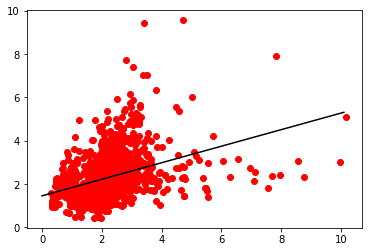

In [10]:
parameters = linear_regression([train_x, train_y])
print(parameters)

t1 = np.arange(0, np.max(train_x), 0.1)
plt.plot(train_x, train_y, 'ro')
plt.plot(t1, parameters[0] + t1*parameters[1], 'k')
plt.show()

## Compare with sklearn

[1.4607143801858906, 0.38138977081613434]


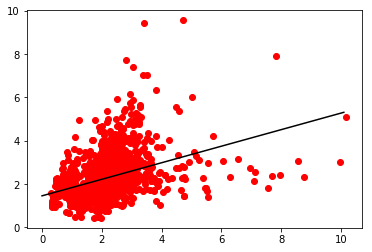

In [11]:
regr = linear_model.LinearRegression()
regr.fit(np.array([[x] for x in train_x]), np.array(train_y))
print([regr.intercept_, regr.coef_[0]])

t1 = np.arange(0, np.max(train_x), 0.1)
plt.plot(train_x, train_y, 'ro')
plt.plot(t1, regr.intercept_ + t1*regr.coef_[0], 'k')
plt.show()

# Logistic regression (with BFGS optimizer)

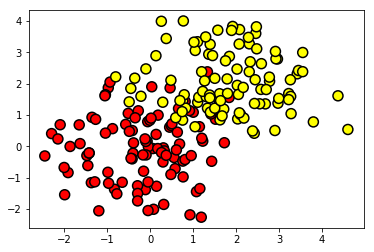

In [12]:
#generate data: two classes that contain groups of normal distributed values
train_data = np.random.normal(size=(100, 2), loc=0)
train_labels = np.zeros(100)

train_data = np.concatenate((train_data, np.random.normal(size=(100, 2), loc=2)))
train_labels = np.concatenate((train_labels, np.ones(100)))

plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.show()

### Logistic regression is simple to linear regression, but now we must lineary separate data. For better visualisation I optimized cost function and found coeficient of line and compare with separator from sklearn.

In [13]:
#some functions for cost function
def sigmoid(values, params):
    return 1.0/(1 + np.exp(-np.dot(values, params[1:])-params[0]))

def single_entropy(values, labels):
    return labels*np.log(values) + (1-labels)*np.log(1-values)

def logistic_regression(train_data):
    cost_function = lambda x: -1/len(train_data)*np.sum(single_entropy(sigmoid(train_data[0], x), train_data[1])) + np.linalg.norm(x)
    params = bfgs_method(cost_function, x=np.array([2.0, 2.0, 2.0]))
    return params

In [14]:
parameters = logistic_regression([train_data, train_labels])
print(parameters)

[-3.27351798  1.49963633  2.0391611 ]


/home/vaden4d/tf/lib/python3.5/site-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/vaden4d/tf/lib/python3.5/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


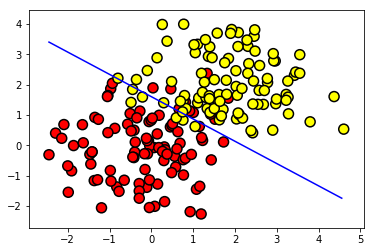

In [15]:
#visualize my separator
points_x = np.arange(np.min(train_data[:, 0]), np.max(train_data[:, 0]), 0.05)

plt.plot(points_x, -parameters[0]/parameters[2]-points_x*parameters[1]/parameters[2], 'b')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.show()

## Compare!

In [16]:
logreg = linear_model.LogisticRegression()
logreg.fit(train_data, train_labels)
print([logreg.intercept_, logreg.coef_[0]])

[array([-2.7586797]), array([ 1.34966955,  1.74046874])]


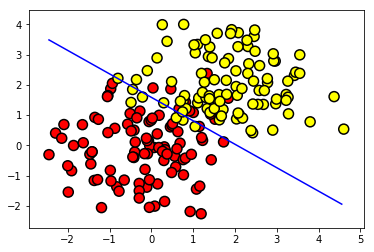

In [17]:
parameters = np.c_[logreg.intercept_, logreg.coef_][0]

points_x = np.arange(np.min(train_data[:, 0]), np.max(train_data[:, 0]), 0.05)

plt.plot(points_x, -parameters[0]/parameters[2]-points_x*parameters[1]/parameters[2], 'b')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.show()

### Almost the same.

# Naive Bayes Classifier

In [18]:
from sklearn import datasets

iris = datasets.load_iris()

In [19]:
train_data = np.array(list([sample, label] for sample, label in zip(iris.data, iris.target)))
np.random.shuffle(train_data)

train_features = train_data[:, 0][:125]
train_labels = train_data[:, 1][:125]

test_features = train_data[:, 0][125:]
test_labels = train_data[:, 1][125:]
#my train and test data. of course, we can use train_test_split from, but I wrote my optional

In [20]:
#naive bayes with counts
def naive_bayes(train_features, train_labels, sample):
    classes = defaultdict(lambda: 0)
    frequencies = defaultdict(lambda: 0)
    
    for features, label in zip(train_features, train_labels):
        classes[label] += 1.0             
        for feature in features:
            frequencies[feature, label] += 1.0        
 
    for feature, label in frequencies:             
        frequencies[feature, label] /= classes[label]
    for label in classes:                       
        classes[label] /= len(train_labels)

    results = np.array([])
    for label in set(train_labels):
        product = 1.0
        for new_feature in sample:
            product *= frequencies[new_feature, label]
        product *= classes[label]
        results = np.append(results, product)
    return np.argmax(results)

#accuracy of method with test set
def accuracy(train_features, train_labels, test_features, test_labels):
    accuracy = np.array([])
    for features, labels in zip(test_features, test_labels):
        accuracy = np.append(accuracy, naive_bayes(train_features, train_labels, features) == labels)
    return len(list(filter(lambda x: x == True, accuracy)))/len(test_labels)

In [21]:
accuracy(train_features, train_labels, test_features, test_labels)

0.76

# K-Means (with Iris dataset)

In [22]:
from sklearn.model_selection import train_test_split
data, labels = iris.data, iris.target

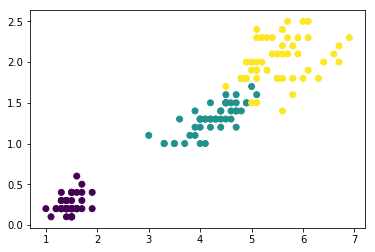

In [23]:
plt.scatter(iris.data[:, 2], iris.data[:, 3], c=labels)
plt.show()

In [24]:
def find_center(x, centers):
    distances = np.array([np.linalg.norm(x-center) for center in centers])
    index = np.argmin(distances)
    return index

def k_means(train_data, num_of_clusters=3):
    current_centers = [[] for i in range(num_of_clusters)]
    next_centers = [[] for i in range(num_of_clusters)]
    for i in range(num_of_clusters):
        current_centers[i] = train_data[i]
    while True:
        clusters = [[] for i in range(num_of_clusters)]
        for feature in train_data:
            found_index = find_center(feature, current_centers)
            clusters[found_index].append(feature)
        for i in range(num_of_clusters):
            next_centers[i] = np.mean(clusters[i], axis=0)
        clusters = [np.array(cluster) for cluster in clusters]
        if set([tuple(next_center) for next_center in next_centers]) == set([tuple(current_center) for current_center in current_centers]): break
        next_centers = np.array(next_centers)
        current_centers = next_centers
    return clusters, next_centers

In [25]:
#shuffled for random finding of the centers
for_shuffle = data[:, 2:4].copy()
np.random.shuffle(for_shuffle)
clusters, centres = k_means(for_shuffle)

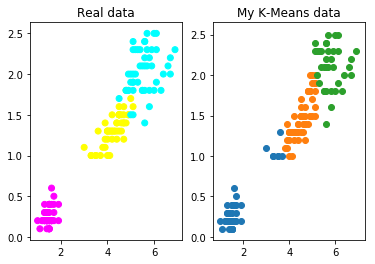

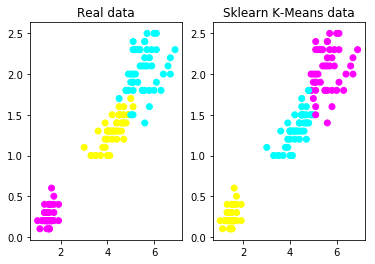

In [26]:
#compare with my method and real data
colormap = np.array(['magenta', 'yellow', 'cyan'])

plt.subplot(1, 2, 1)
plt.scatter(iris.data[:, 2], iris.data[:, 3], c=colormap[labels])
plt.title('Real data')

plt.subplot(1, 2, 2)
plt.scatter(clusters[0][:, 0], clusters[0][:, 1])
plt.scatter(clusters[1][:, 0], clusters[1][:, 1])
plt.scatter(clusters[2][:, 0], clusters[2][:, 1])
plt.title('My K-Means data')
plt.show()

#compare real data and sklearn realization
colormap = np.array(['magenta', 'yellow', 'cyan'])

plt.subplot(1, 2, 1)
plt.scatter(iris.data[:, 2], iris.data[:, 3], c=colormap[labels])
plt.title('Real data')

from sklearn.cluster import KMeans
clusterizer = KMeans(n_clusters=3)
clusterizer.fit(iris.data[:, 2:4])

plt.subplot(1, 2, 2)
plt.scatter(iris.data[:, 2], iris.data[:, 3], c=colormap[clusterizer.labels_])
plt.title('Sklearn K-Means data')
plt.show()

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(labels, np.sort(clusterizer.labels_))

0.97333333333333338

# Gaussian discriminant analysis (or Linear discriminant analysis)

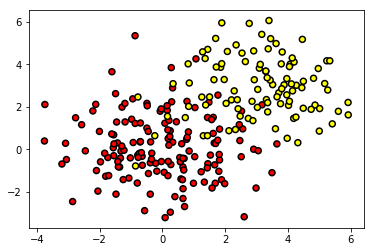

In [28]:
#generate data: two classes that contain groups of normal distributed values
class_size_1 = 150
class_size_2 = 100

mean_1 = 0.0
mean_2 = 3.0

std_1 = 1.5
std_2 = 1.5

train_data = np.random.normal(size=(class_size_1, 2), loc=mean_1, scale=std_1)
train_labels = np.zeros(class_size_1)

train_data = np.concatenate((train_data, np.random.normal(size=(class_size_2, 2), loc=mean_2, scale=std_2)))
train_labels = np.concatenate((train_labels, np.ones(class_size_2)))

plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.show()

#generate test data
test_data = np.random.normal(size=(class_size_1 // 5, 2), loc=mean_1, scale=std_1)
test_labels = np.zeros(class_size_1 // 5)

test_data = np.concatenate((test_data, np.random.normal(size=(class_size_2 // 5, 2), loc=mean_2, scale=std_2)))
test_labels = np.concatenate((test_labels, np.ones(class_size_2 // 5)))

## Suppose:

### y ~ Bernoully(a)
### x | y=0 ~ N(m_1, cov)
### x | y=1 ~ N(m_2, cov)

In [29]:
#compute means and cov 
def gda_method_computations(train_data, train_labels):
    classes = defaultdict(lambda: 0)
    for label in train_labels:
        classes[label] += 1.0/len(train_labels)
    
    first_mean_est = np.sum(np.compress(train_labels == 0, train_data, axis=0), axis=0)/len(np.extract(train_labels == 0, train_labels))
    second_mean_est = np.sum(np.compress(train_labels == 1, train_data, axis=0), axis=0)/len(np.extract(train_labels == 1, train_labels))
    
    means = [first_mean_est if train_labels[i] == 0 else second_mean_est for i in range(len(train_labels))]
    residuals = train_data - means
    
    cov_est = np.zeros((len(train_data[0]), len(train_data[0])))
    for element in residuals:
        cov_est += np.outer(element, element)
    cov_est /= len(train_labels)

    return classes, first_mean_est, second_mean_est, cov_est

#evaluate for two classes
def gda_method_evaluate(class_probability, first_mean, second_mean, cov, sample):
    result = np.array([])
    result = np.append(result, multivariate_normal.pdf(sample, first_mean, cov=cov) * class_probability[0])
    result = np.append(result, multivariate_normal.pdf(sample, second_mean, cov=cov) * class_probability[1])
    return np.argmax(result)

#accuracy of the test data
def gda_accuracy(class_probability, first_mean, second_mean, cov, test_data, test_labels):
    result = np.array([])
    for sample, label in zip(test_data, test_labels):
        result = np.append(result, gda_method_evaluate(class_probability, first_mean, second_mean, cov, sample) == label)
    return len(np.extract(result == 1, result))/len(test_labels)

In [30]:
class_prob, f_mean, s_mean, cov = gda_method_computations(train_data, train_labels)

In [31]:
gda_accuracy(class_prob, f_mean, s_mean, cov, test_data, test_labels)

0.8

### Compare with sklearn:

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(train_data, train_labels)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [33]:
predicted_labels = clf.predict(test_data)
accuracy_score(test_labels, predicted_labels)

0.80000000000000004

## PCA (of course, with IRIS dataset)

In [34]:
from sklearn import datasets

iris = datasets.load_iris()

train_data = iris.data[:, 1:4]
train_labels = iris.target

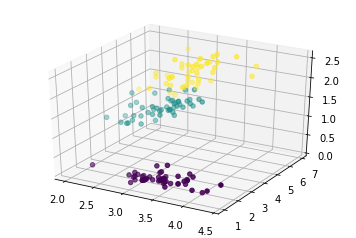

In [35]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(iris.data[:, 1], iris.data[:, 2], iris.data[:, 3], c=iris.target)
plt.show()

In [36]:
#pca for train_data
def decomposition(train_data, subspace_dim=2):
    cov = np.cov(train_data.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    
    eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[i]) for i in range(len(eigenvalues))]
    eigen_pairs.sort(key=lambda x: x[0], reverse=True)
    compression_matrix = []
    for value in eigen_pairs:
        compression_matrix.append(value[1].T)
    compression_matrix = np.array(compression_matrix)[:, 0:subspace_dim]
    print(compression_matrix)
    
    transformed_data = [np.matmul(compression_matrix.T, sample.T) for sample in train_data]
    transformed_data = np.array(transformed_data)
    return transformed_data

In [37]:
compr_data = decomposition(iris.data)

[[ 0.36158968 -0.65653988]
 [-0.08226889 -0.72971237]
 [ 0.85657211  0.1757674 ]
 [ 0.35884393  0.07470647]]


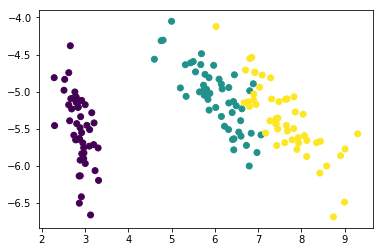

In [38]:
#visualize
plt.scatter(compr_data[:, 0], compr_data[:, 1], c=train_labels)
plt.show()

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(iris.data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [40]:
compres_data = pca.components_.T

In [41]:
compres_data

array([[ 0.36158968,  0.65653988],
       [-0.08226889,  0.72971237],
       [ 0.85657211, -0.1757674 ],
       [ 0.35884393, -0.07470647]])

# SVM

In [42]:
from scipy.optimize import minimize

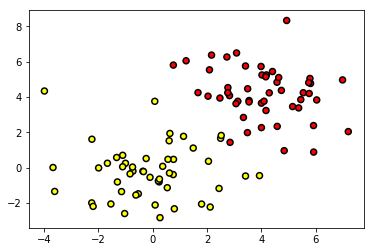

In [382]:
#generate data: two classes that contain groups of normal distributed values
class_size_1 = 50
class_size_2 = 50

mean_1 = 0.0
mean_2 = 4.0

std_1 = 1.5
std_2 = 1.5

train_data = np.random.normal(size=(class_size_1, 2), loc=mean_1, scale=std_1)
train_labels = np.ones(class_size_1)

train_data = np.concatenate((train_data, np.random.normal(size=(class_size_2, 2), loc=mean_2, scale=std_2)))
train_labels = np.concatenate((train_labels, -np.ones(class_size_2)))

plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.show()

In [383]:
def linear_kernel(left, right):
    return np.dot(left, right)

def polinomial_kernel(left, right, dim=2):
    return (1 + np.dot(left, right))**dim

def cost_function_compute(train_data, train_labels, kernel):
    def cost_function(params):        
        temporary1 = np.outer(params, params)
        temporary2 = np.outer(train_labels, train_labels)
        temporary3 = np.array([[kernel(x_i, x_j) for x_j in train_data] for x_i in train_data])
        result = np.sum(params) - 0.5*np.sum(temporary1*temporary2*temporary3)
        return -result
    return cost_function

def svm(train_data, train_labels, kernel=linear_kernel):
    cost_func = cost_function_compute(train_data, train_labels, kernel)
    constraint = 0.5/(2*len(train_labels))

    cons = []
    bounds = []
    for i in range(len(train_labels)):
        bounds.append((0, constraint))
    cons.append({'type': 'eq', 'fun': lambda x: np.dot(x, train_labels)})
    bounds = tuple(bounds)
    cons = tuple(cons)
    res = minimize(cost_func, x0=np.zeros(len(train_labels)), method='SLSQP', constraints=cons, bounds=bounds)
    
    if kernel==polinomial_kernel:
        
        phi_values = np.array([[1.0, sample[0]**2, np.sqrt(2)*sample[0]*sample[1], sample[1]**2, 
                               np.sqrt(2)*sample[0], np.sqrt(2)*sample[1]] for sample in train_data])
    
        indices = np.where(res.x != 0)
        coefficients = np.sum([param*label*sample 
                                        for param, label, sample 
                                        in zip(res.x, train_labels, phi_values)], 
                                        axis=0)
    
        intercept = np.mean([-np.dot(coefficients, phi_values[i]) + train_labels[i] for i in indices[0]])

    
    if kernel==linear_kernel:
        
        coefficients = np.sum([param*label*sample 
                                    for param, label, sample 
                                    in zip(res.x, train_labels, train_data)],
                                    axis=0) 
        indices = np.where(res.x != 0)
        
        support_vectors = np.take(train_data, indices, axis=0)[0]
        support_labels = np.take(train_labels, indices, axis=0)[0]
        
        intercept = np.mean([support_label - np.dot(coefficients, support_vector) 
                                    for support_label, support_vector 
                                    in zip(support_labels, support_vectors)])
    
    coefficients = np.insert(coefficients, 0, intercept)
    return coefficients, indices

In [384]:
parameters, indices = svm(train_data, train_labels, kernel=linear_kernel)
print(parameters)

[ 0.86023    -0.20002109 -0.2231135 ]


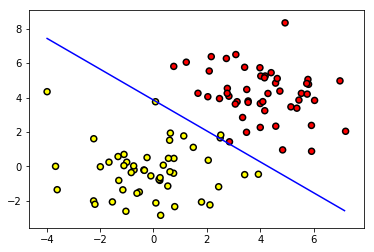

In [385]:
points_x = np.arange(np.min(train_data[:, 0]), np.max(train_data[:, 0]), 0.05)

plt.plot(points_x, -parameters[0]/parameters[2]-points_x*parameters[1]/parameters[2], 'b')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, 
cmap='autumn', edgecolors='black', linewidth=1.5)

plt.show()

In [386]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(train_data, train_labels)
params = np.c_[clf.intercept_, clf.coef_][0]

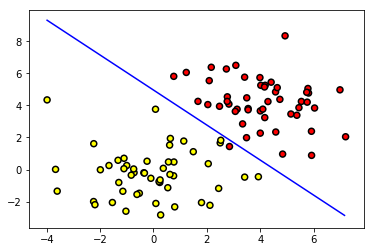

In [387]:
points_x = np.arange(np.min(train_data[:, 0]), np.max(train_data[:, 0]), 0.05)

plt.plot(points_x, -params[0]/params[2]-points_x*params[1]/params[2], 'b')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, 
cmap='autumn', edgecolors='black', linewidth=1.5)
plt.show()

In [388]:
params, indices = svm(train_data, train_labels, kernel=polinomial_kernel)
print(params)

[  2.32018603e+00  -1.27031464e-14  -4.92554824e-02  -8.90125597e-02
  -5.70556299e-02  -5.99909038e-02  -4.79675521e-02]


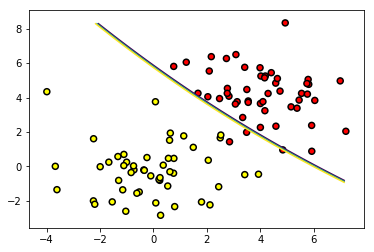

In [389]:
x = np.arange(np.min(train_data[:, 0]), np.max(train_data[:, 0]), 0.05)
y = np.arange(np.min(train_data[:, 1]), np.max(train_data[:, 1]), 0.05)
X, Y = np.meshgrid(x, y)
Z = params[0] + params[1] + params[2]*X**2 + np.sqrt(2)*X*Y*params[3] + params[4]*Y**2 + np.sqrt(2)*X*params[5] + np.sqrt(2)*Y*params[6]

plt.contour(X, Y, Z, levels=[-0.05, 0.0, 0.05])
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, 
cmap='autumn', edgecolors='black', linewidth=1.5)
plt.show()

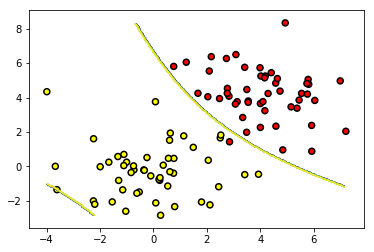

In [390]:
clf_poly = SVC(kernel='poly', degree=2)
clf_poly.fit(train_data, train_labels)

Z = clf_poly.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)
plt.contour(X, Y, Z)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, 
cmap='autumn', edgecolors='black', linewidth=1.5)
plt.show()

# Neural Network

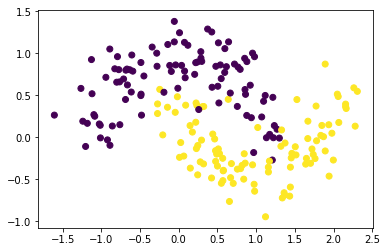

In [2]:
train_data, train_labels = datasets.make_moons(200, noise=0.20)
test_data, test_labels = datasets.make_moons(20, noise=0.20)
plt.scatter(train_data[:,0], train_data[:,1], c=train_labels)
plt.show()

In [3]:
num_examples = len(train_labels)
nn_input_dim = 2
nn_output_dim = 2
nn_hidden_layers = 20

epsilon = 0.01 
reg_lambda = 0.01 

In [4]:
W1 = np.random.normal(0.0, 0.05, (nn_input_dim, nn_hidden_layers))
b1 = np.random.normal(0.0, 0.05, (1, nn_hidden_layers))
W2 = np.random.normal(0.0, 0.05, (nn_hidden_layers, nn_output_dim))
b2 = np.random.normal(0.0, 0.05, (1, nn_output_dim))

## My model is two inputs, one hidden layer and two outputs. Activation function - tanh. Cost function - meaned cross-entropy with L2-regularization of weights.
### z1 = x*W1 + b1
### a1 = tanh(z1)
### z2 = a1*W2 + b2
### output = softmax(z2)

In [5]:
def loss(W1, b1, W2, b2, train_data, train_labels):
    z1 = train_data.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    logprobs = -np.log(probs[range(num_examples), train_labels])
    data_loss = np.sum(logprobs)
    #regulatization
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1.0/num_examples * data_loss

In [6]:
def predict(W1, b1, W2, b2, x):
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)[0]

In [7]:
#backpropagation
def train(W1, b1, W2, b2, train_data, train_labels, num_of_iter=10000):
    for i in range(0, num_of_iter):
        z1 = train_data.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        if i % 1000 == 0:
            print('Iteration ' + str(i) + ': Loss =', loss(W1, b1, W2, b2, train_data, train_labels))
        
        delta_last = probs
        delta_last[range(num_examples), train_labels] -= 1
        
        dW2 = (a1.T).dot(delta_last)
        db2 = np.sum(delta_last, axis=0, keepdims=True)
        delta_prev = delta_last.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(train_data.T, delta_prev)
        db1 = np.sum(delta_prev, axis=0)

        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
                           
    return W1, b1, W2, b2

In [8]:
def accuracy_score(y_real, y_predicted):
    return np.mean(y_real == y_predicted)

In [9]:
W1, b1, W2, b2 = train(W1, b1, W2, b2, train_data, train_labels)

Iteration 0: Loss = 0.7073382077558587
Iteration 1000: Loss = 0.10779706969486196
Iteration 2000: Loss = 0.09864295888021626
Iteration 3000: Loss = 0.09579109761708185
Iteration 4000: Loss = 0.09382243360714246
Iteration 5000: Loss = 0.09204607444187556
Iteration 6000: Loss = 0.09024067119418669
Iteration 7000: Loss = 0.08851521052637729
Iteration 8000: Loss = 0.08689982854263463
Iteration 9000: Loss = 0.08547320415873905


In [10]:
y_predicted = np.array([predict(W1, b1, W2, b2, sample) for sample in test_data])
accuracy_score(test_labels, y_predicted)

0.95